# Custom Neural Network

This is an evaluation of the custom fully dense neural network model I made from scratch in this project.

We will be testing how my model performs on two popular datasets:

- California Housing DataSet (https://www.kaggle.com/datasets/camnugent/california-housing-prices)
- MNIST Digit Recognization DataSet (https://www.kaggle.com/competitions/digit-recognizer/data)

My custom model was developed using the NumPy library and my own mathematical knowledge.

## California Housing Data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Data Preparation

In [3]:
housing_data = pd.read_csv('Datasets\CaliforniaHousing.csv')
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


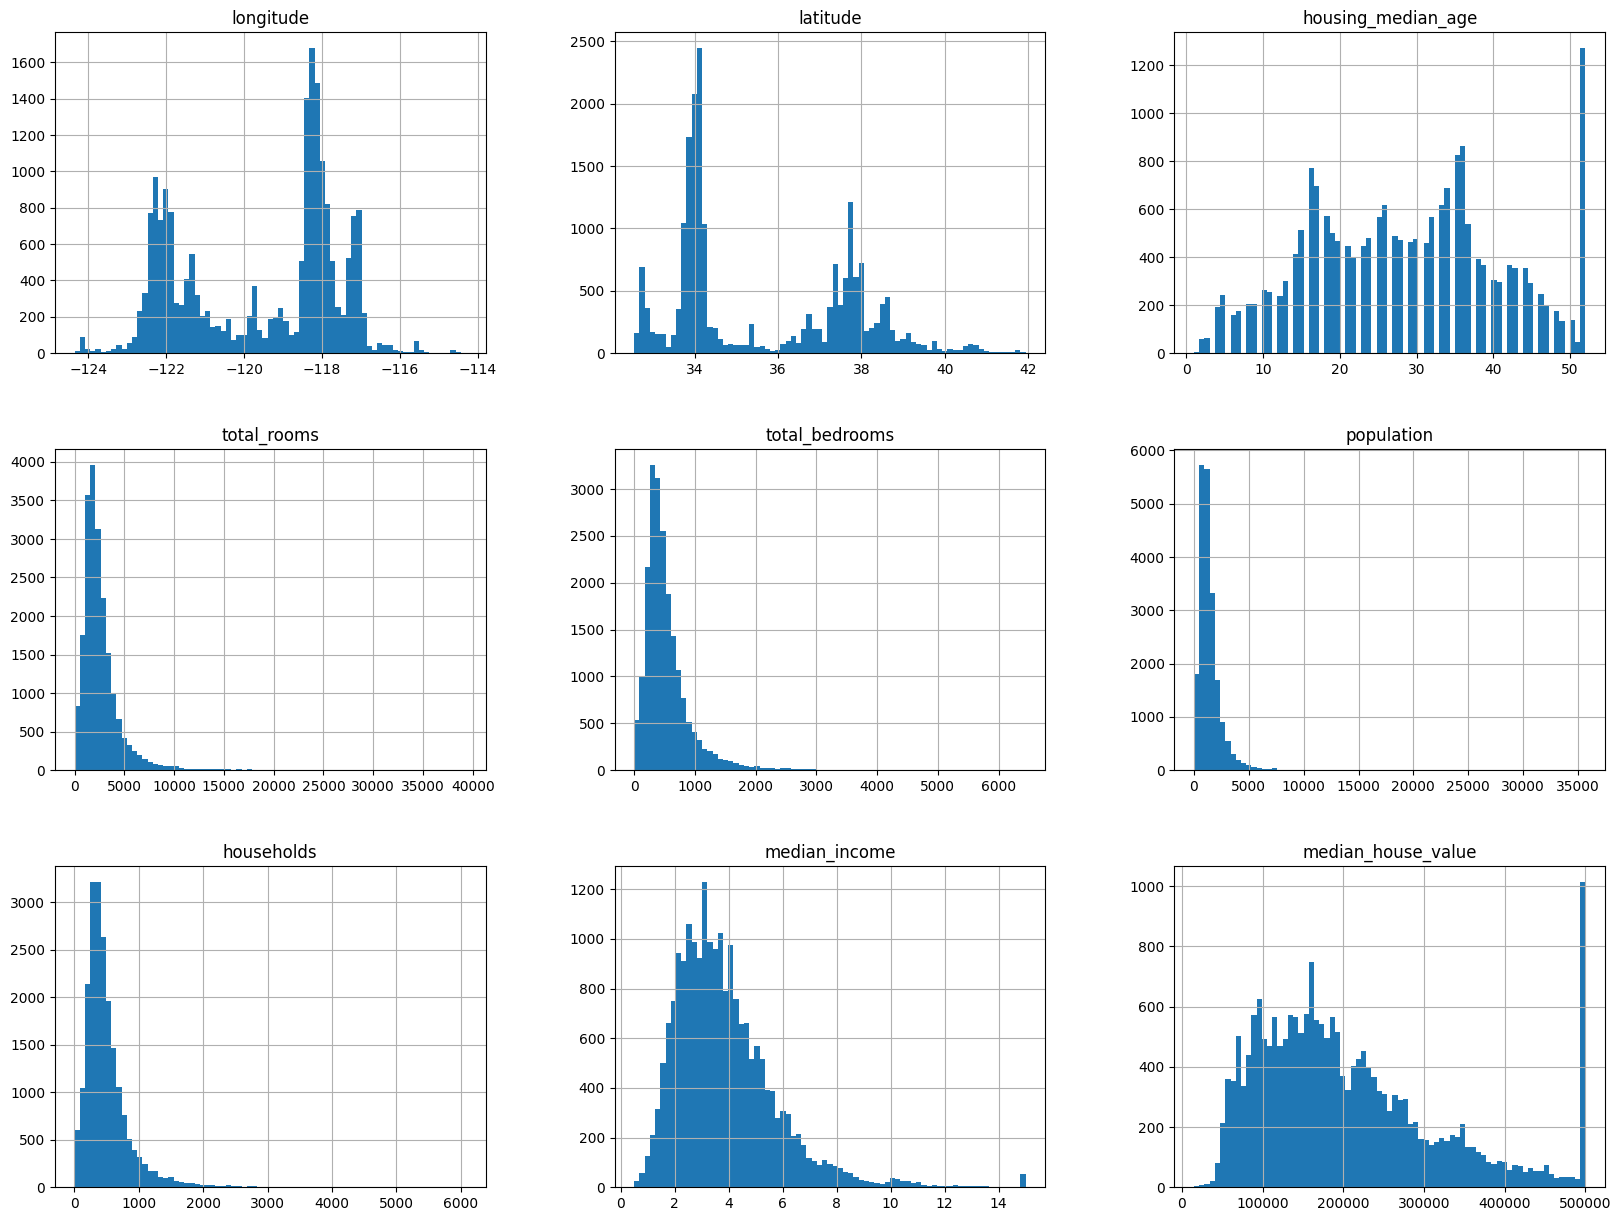

In [4]:
housing_data.hist(bins=75, figsize=(20,15))
plt.show()

C:\Users\Jason_yj4bjfp\AppData\Local\Temp\ipykernel_7800\3710475567.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  c_mat = housing_data.corr()


<AxesSubplot: >

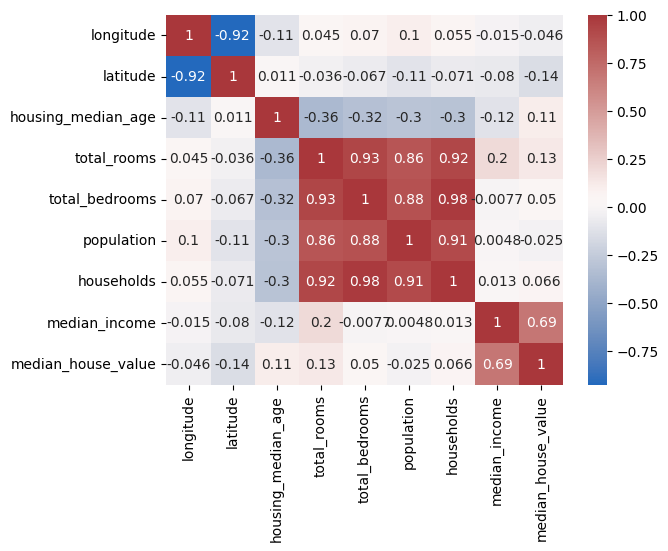

In [5]:
c_mat = housing_data.corr()
sns.heatmap(c_mat, annot=True,  linewidths=0, cmap='vlag')

### Cleaning the DataSet

First, we scramble the dataset so there will be no permuation bias.

In [6]:
housing_data = housing_data.sample(frac=1, random_state=12)
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
6906,-118.13,34.04,42.0,2205.0,451.0,1392.0,423.0,4.3646,211400.0,<1H OCEAN
767,-122.09,37.65,27.0,2630.0,722.0,1414.0,634.0,2.8203,195200.0,NEAR BAY
10555,-117.71,33.63,16.0,2497.0,500.0,1357.0,456.0,4.5909,241800.0,<1H OCEAN
17456,-120.43,34.69,33.0,2054.0,373.0,1067.0,358.0,3.6023,128300.0,NEAR OCEAN
20617,-121.53,39.06,20.0,561.0,109.0,308.0,114.0,3.3021,70800.0,INLAND


For this project, we will drop the data points with Nan values.

In [7]:
housing_data = housing_data.dropna(subset=["total_bedrooms"])

Next, we will convert the text and categorical values into quantitative ones.

In [8]:
housing_data[["ocean_proximity"]].value_counts()

ocean_proximity
<1H OCEAN          9034
INLAND             6496
NEAR OCEAN         2628
NEAR BAY           2270
ISLAND                5
dtype: int64

In [9]:
ocean_proximity_mapping = {'<1H OCEAN': 0, 'INLAND': 1, 'NEAR OCEAN': 2, 'NEAR BAY': 3, 'ISLAND': 4}
housing_data['ocean_proximity'] = housing_data['ocean_proximity'].map(ocean_proximity_mapping)
housing_data['ocean_proximity'].head()

6906     0
767      3
10555    0
17456    2
20617    1
Name: ocean_proximity, dtype: int64

### Creating Training and Test Sets

Now that we have cleaned our data, we can create the test and training sets:

(split_train_test function was borrowed from the O'Reily ML Textbook by Geron Aurelien)

In [10]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

We will use a training-test set ratio of 30:70.

In [11]:
train_set, test_set = split_train_test(housing_data, 0.3)
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
16570,-121.42,37.75,33.0,1999.0,368.0,1061.0,390.0,3.5242,121400.0,1
16160,-122.49,37.78,42.0,2723.0,579.0,1419.0,519.0,3.6429,328400.0,3
15580,-116.86,33.02,17.0,401.0,68.0,251.0,69.0,4.6518,170200.0,0
1033,-120.65,38.50,10.0,1783.0,337.0,638.0,262.0,2.6500,116700.0,1
9945,-122.39,38.37,33.0,1066.0,191.0,403.0,163.0,6.8000,240800.0,0


### Feature Scaling

In order for a neural network to perform the best, we must scale the training data down to the same scale. We will use the Sci-kit Learn Z-score normalization scaler for this.

In [12]:
from sklearn.preprocessing import StandardScaler

z_score_scaler = StandardScaler()

fitted_train_set = z_score_scaler.fit_transform(train_set)
train_X = pd.DataFrame(fitted_train_set, columns=train_set.columns).drop("median_house_value", axis=1).values
train_y = train_set["median_house_value"].values

scaled_test_set = z_score_scaler.transform(test_set)
test_X = pd.DataFrame(scaled_test_set, columns=test_set.columns).drop("median_house_value", axis=1).values
test_y = test_set["median_house_value"].values

train_X[:3]

array([[-0.91314586,  0.97843694,  0.341933  , -0.28760506, -0.39877194,
        -0.31618872, -0.28312996, -0.17606873,  0.08585539],
       [-1.44836297,  0.9924664 ,  1.05826123,  0.03957938,  0.0961044 ,
        -0.01104782,  0.0496782 , -0.11356886,  2.07303248],
       [ 1.36777939, -1.23354228, -0.93153941, -1.00976077, -1.10238759,
        -1.00659132, -1.11128051,  0.41765367, -0.90773316]])

Combining the shuffling and scaling into a single function:

In [13]:
def shuffle_scale(data, ratio):
    train_set, test_set = split_train_test(data, ratio)
    z_score_scaler = StandardScaler()

    fitted_train_set = z_score_scaler.fit_transform(train_set)
    train_X = pd.DataFrame(fitted_train_set, columns=train_set.columns).drop("median_house_value", axis=1).values
    train_y = train_set["median_house_value"].values

    scaled_test_set = z_score_scaler.transform(test_set)
    test_X = pd.DataFrame(scaled_test_set, columns=test_set.columns).drop("median_house_value", axis=1).values
    test_y = test_set["median_house_value"].values
    
    return train_X, train_y, test_X, test_y

Now that we have our training and test sets, we can being training our model.

### Training Model

For our model, we will use a 4 layer deep fully connected neural network with a ReLu activation function for each hidden layer.

Creating a model using my custom package is similar to Tensorflow's method.

In [36]:
from Model import *

my_model = Model(Layers=[
    Dense_Layer(input_shape=9,output_shape=5, activation_func="relu"),
    Dense_Layer(input_shape=5,output_shape=6, activation_func="relu"),
    Dense_Layer(input_shape=6,output_shape=3, activation_func="relu"),
    Output_Layer(input_shape=3,output_shape=1)
])

my_model.summary()

Dense Layer  | 5 neurons | 9 weights | 1 bias
Dense Layer  | 6 neurons | 5 weights | 1 bias
Dense Layer  | 3 neurons | 6 weights | 1 bias
Output Layer | 1 outputs | 3 weights | 1 bias
Input Shape: 9
Output Shape: 1


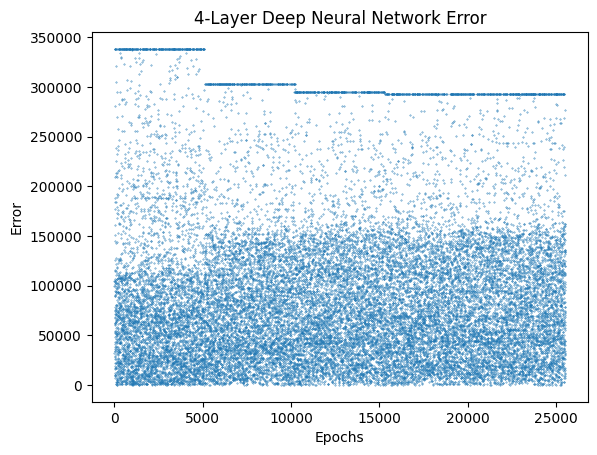

In [37]:
long_train_err = []
long_test_err = []
avg_train_err = []
avg_test_err = []

for x in range(5):
    train_X, train_y, test_X, test_y = shuffle_scale(housing_data, 0.25)
    train_err = my_model.fit(train_X, train_y, learning_rate=0.0001)
    train_err = [x[0] for x in train_err]
    test_err = []
    for i in range(len(test_X)):
        test_err.append(abs(my_model.forward_pass(test_X[i])[0]-test_y[i]))
    long_test_err = long_test_err+test_err
    long_train_err = long_train_err+train_err
    avg_train_err.append(np.mean(train_err))
    avg_test_err.append(np.mean(test_err))

plt.scatter(range(len(long_test_err)),long_test_err, s=0.1)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("{layers}-Layer Deep Neural Network Error".format(layers=len(my_model.get_Layers())))
plt.show()

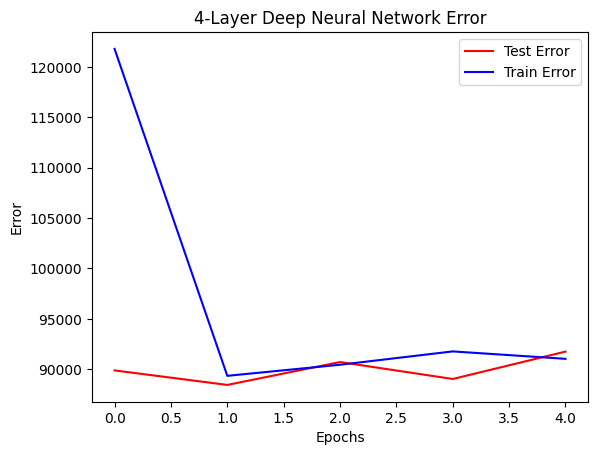

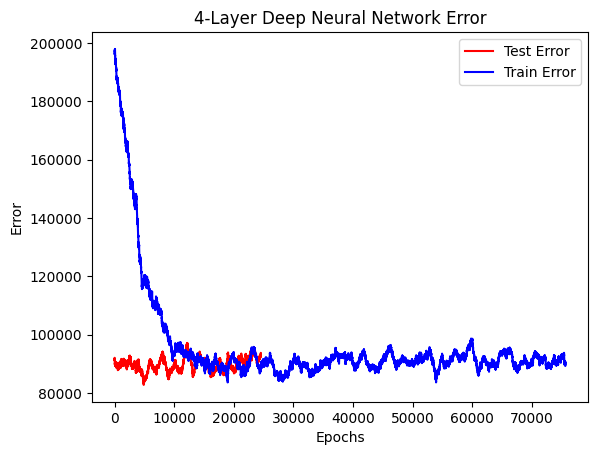

In [39]:
plt.plot(avg_test_err, label="Test Error", color="red")
plt.plot(avg_train_err, label="Train Error", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.title("{layers}-Layer Deep Neural Network Error".format(layers=len(my_model.get_Layers())))
plt.show()

mv_train_err = np.convolve(long_train_err, np.ones(1000)/1000, mode='valid')


mv_test_err = np.convolve(long_test_err, np.ones(1000)/1000, mode='valid')

plt.plot(mv_test_err, label="Test Error", color="red")
plt.plot(mv_train_err, label="Train Error", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.title("{layers}-Layer Deep Neural Network Error".format(layers=len(my_model.get_Layers())))
plt.show()

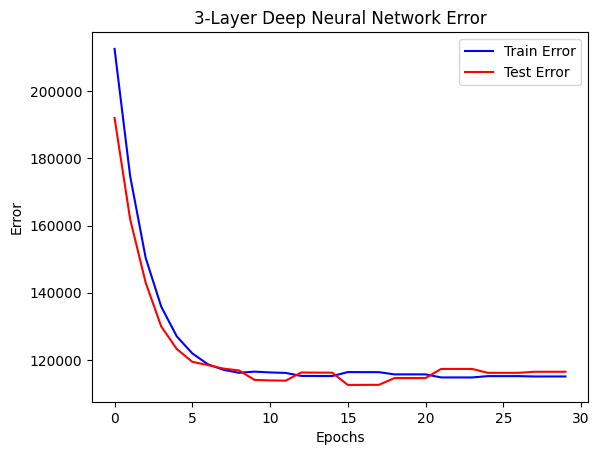

In [97]:
import tensorflow as tf

tf_model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='relu', input_shape=(9,)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

tf_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss='mean_squared_error')

loss = []
accuracy = []

for x in range(10):
    train_X, train_y, test_X, test_y = shuffle_scale(housing_data, 0.25)
    history = tf_model.fit(train_X, train_y, epochs=3, batch_size=10, verbose = 0, validation_data=(test_X, test_y))
    loss += history.history['loss']
    accuracy += history.history['val_loss']
loss = [np.sqrt(x) for x in loss]
accuracy = [np.sqrt(x) for x in accuracy]
plt.plot(loss, label="Train Error", color="blue")
plt.plot(accuracy, label="Test Error", color="red")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.title("{layers}-Layer Deep Neural Network Error".format(layers=3))
plt.show()

## MNIST Digit Recognizer DataSet

Moving onto the MNIST Digit Recongizer DataSet, we will be classifying handwritten numbers into their corresponding digits.